<a href="https://colab.research.google.com/github/Jzakai/computer-vision/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# custom [AutoEncoder] model
The input to the model is the Gray Scale Image and it's output  is a colored image.
Data was Split into training and validation splits (80%, 20%).
Model was trained on the training data.
Final loss value is shown with a graphical representation of the training and validation loss.

In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])



image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
(gs_img, rgb_img), _ = image_dataset[0]  # _ is the image class which we don't need for this assignment

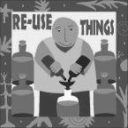

In [ ]:
transforms.functional.to_pil_image(gs_img)

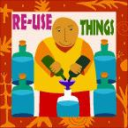

In [ ]:
transforms.functional.to_pil_image(rgb_img)

In [ ]:
print(len(image_dataset))

9144


In [ ]:
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
split = int(0.8 * len(image_dataset))
indices = list(range(len(image_dataset)))
'''if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        '''
train_indices,test_indices = indices[:split], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

#image_dataset[0] = transforms. transforms.ToTensor()


train_loader = DataLoader(image_dataset, batch_size=32,sampler=train_sampler)
test_loader = DataLoader(image_dataset, batch_size=32,sampler=test_sampler)

In [ ]:
type(train_loader)


torch.utils.data.dataloader.DataLoader

In [ ]:
class CustomSegModel(nn.Module):  # Unet architecture based
    def __init__(self, in_channels, out_channels):
        super(CustomSegModel, self).__init__()
        #down sample only 6 times bec 128
        # up sample by same amt of times to get same image

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 80, kernel_size=3, padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(80, 100, kernel_size=3, padding=1,stride=2),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(100, 200, kernel_size=3, padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(200, 256, kernel_size=3, padding=1,stride=2),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256,256 , kernel_size=3, padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1,stride=1),
            nn.ReLU(inplace=True),

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 200, kernel_size=2, stride=2),
            nn.Conv2d(200, 150, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(150, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 100, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(100, 100, kernel_size=2, stride=2),

            nn.Conv2d(100, 100, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(100, 80, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(80, 80, kernel_size=2, stride=2),

            nn.Conv2d(80, 64, kernel_size=3, padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1,stride=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

In [ ]:
# Example usage
in_channels = 1  # for RGB images (3 channels)
out_channels = 3  # for 3 classes

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device=torch.device("cuda:0")

model = CustomSegModel(in_channels, out_channels).to(device)

In [ ]:
from torch.optim import Adam
num_epochs = 10
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean')

print(f'Using device {device}')

Using device cuda:0


In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for (batch_X, batch_y),_ in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    batch_y = batch_y.squeeze(dim=1)

    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for (val_batch_X, val_batch_y),_ in test_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)
      val_batch_y = val_batch_y.squeeze(dim=1)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      #val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      #correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}.')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=0.10289913868594325, val_loss=0.02629845891692142.
Epoch: 1, train_loss=0.02215845204954144, val_loss=0.02057272866278665.
Epoch: 2, train_loss=0.019324379467730485, val_loss=0.01736595613001141.
Epoch: 3, train_loss=0.01650148080494858, val_loss=0.015851336113753306.
Epoch: 4, train_loss=0.01481490008950996, val_loss=0.014336990484232873.
Epoch: 5, train_loss=0.014223984196783742, val_loss=0.014174298936344703.
Epoch: 6, train_loss=0.01369743783090896, val_loss=0.013752789592064024.
Epoch: 7, train_loss=0.013377928323326722, val_loss=0.013385222975326799.
Epoch: 8, train_loss=0.013138612682588093, val_loss=0.012985990292491263.
Epoch: 9, train_loss=0.012889139368488067, val_loss=0.01288317934023697.
Training complete on device cuda:0.
CPU times: user 12min 16s, sys: 8.76 s, total: 12min 25s
Wall time: 12min 49s


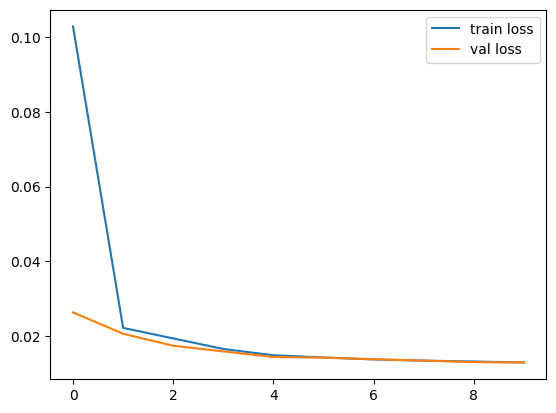

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')

plt.legend()
plt.show()